In [1]:
from collections import defaultdict
from itertools import count


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


from mesa import Model, Agent
from mesa.experimental.cell_space import CellAgent, OrthogonalMooreGrid
from mesa.experimental.cell_space.cell import Cell
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation



class Animal(CellAgent):

    def __init__(self, model, cell, energy_repro_treshold=4):
        super().__init__(model)
        assert isinstance(cell, Cell)
        self.energy_repro_treshold = energy_repro_treshold
        self.cell = cell
        self.energy = self.random.randrange(2, 6)
                
    def reproduce(self):
        empty = [cell for cell in self.cell.neighborhood if cell.is_empty]
        if (self.random.random() < self.p_reproduce) and (empty) and (self.energy >=self.energy_repro_treshold):
            child = self.__class__(self.model, self.random.choice(empty))

            energy = self.energy/2
            child.energy = energy
            self.energy = energy

    def get_neighbors(self):
        neighbors = defaultdict(list)
        for cell in self.cell.neighborhood:
            if cell.is_empty:
                neighbors['empty'].append(cell)
            else:
                for agent in cell.agents:
                    neighbors[agent.__class__].append(cell)            
        return neighbors
    
class Sheep(Animal):
    _instances = 0
    p_reproduce = 0.05
    
    @property
    def i(self):
        """convert the y-coordinate of the cell into the row index (i) 
        for the numpy array for the grass"""
        return self.cell.coordinate[1]
    
    @property
    def j(self):
        """convert the x-coordinate of the cell into the column index (j) 
        for the numpy array for the grass"""        
        return self.cell.coordinate[0]
        
    def step(self):
        self.energy -= 1
        
        if self.energy <= 0:
            self.remove()
            return

        # try to move
        try:
            cell = self.random.choice(self.get_neighbors()['empty'])
        except IndexError:
            pass
        else:
            self.cell = cell
        
        # eat
        energy = self.model.grass[self.i, self.j]
        self.energy += energy
        self.model.grass[self.i, self.j] -= energy            

        # breed
        self.reproduce()            


class Wolf(Animal):
    _instances = 0
    p_reproduce = 0.04
    
    def step(self):
        self.energy -= 1
        
        if self.energy <= 0:
            self.remove()
            return

        # try to move
        try:
             cell = self.random.choice(self.get_neighbors()[Sheep])
        except IndexError:
            pass
        else:
            self.cell = cell
            sheep = [agent for agent in self.cell.agents if isinstance(agent, Sheep)]
            sheep = self.random.choice(sheep)
            sheep.remove()
            self.energy += sheep.energy
            
        self.reproduce()


class PredatorPreyModel(Model):
    
    def __init__(self, width=20, height=20, sheep_density=0.20, wolf_density=0.01,
                regrowth_p=0.1, seed=None):
        super().__init__(seed=seed)
        Wolf._instances = 0
        Sheep._instances = 0
        self.width = width
        self.height = height
        self.regrowth_p = regrowth_p
        
        self.grid = OrthogonalMooreGrid((self.height, self.width), torus=True)
        self.grass = np.ones((self.height, self.width))
        self.datacollector = DataCollector({'wolves' : lambda m: len(m.agents_by_type[Wolf]),
                                            'sheep' : lambda m: len(m.agents_by_type[Sheep]),
                                            'grass' : lambda m: np.sum(m.grass)})
        
        n_cells = width * height
        n_sheep = int(round(sheep_density * n_cells))
        n_wolves = int(round(wolf_density * n_cells))
        
        for klass, n in ((Wolf, n_wolves),(Sheep, n_sheep)):
            for _ in range(n):
                agent = klass(self, self.random.choice(list(self.grid.empties)))
        
        self.datacollector.collect(self)
        
    def step(self):
        # regrow grass
        self.grass[self.grass != 0] += 1/3
        self.grass[(model.grass == 0) & (np.random.rand(*model.grass.shape) <= self.regrowth_p)] = 1/3    
        self.grass = np.minimum(self.grass, 5)
        
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)



def visualize_model(model):
    green = sns.color_palette()[2] + (1,)
    red = sns.color_palette()[3] + (1,)
    transparent = sns.color_palette()[3] + (0,)
    
    x = []
    y = []
    colors = []
    for cell in model.grid.all_cells:
        x.append(cell.coordinate[0])
        y.append(cell.coordinate[1])
        
        if not cell.is_empty:
            color = red if isinstance(cell.agents[0], Wolf) else green
        else:
            color = transparent
        
        colors.append(color)
        
    sns.set_style('white')
    
    fig, ax = plt.subplots()
    ax.imshow(model.grass, vmin=0, vmax=5, cmap='viridis', origin='lower')
    ax.scatter(x,y, s=200, c=np.asarray(colors, dtype=object))
    ax.set_aspect('equal')
    # ax.set_xticks([])
    # ax.set_yticks([])
    
    return fig
    
    

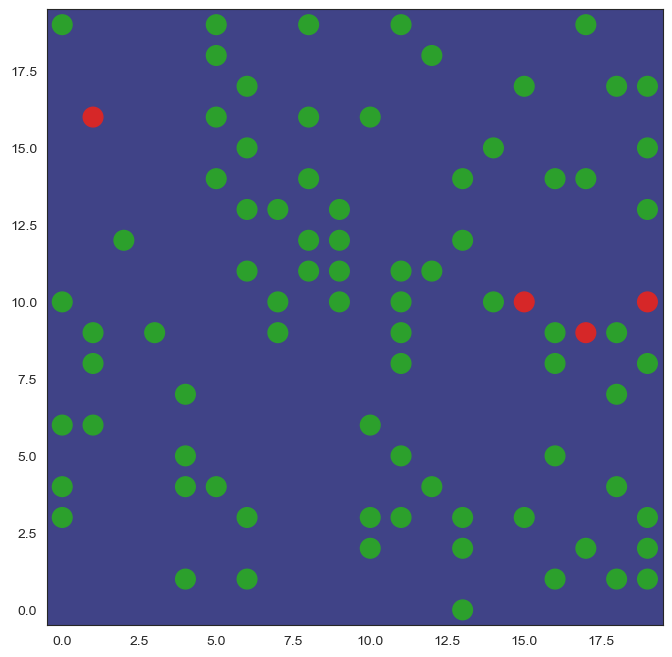

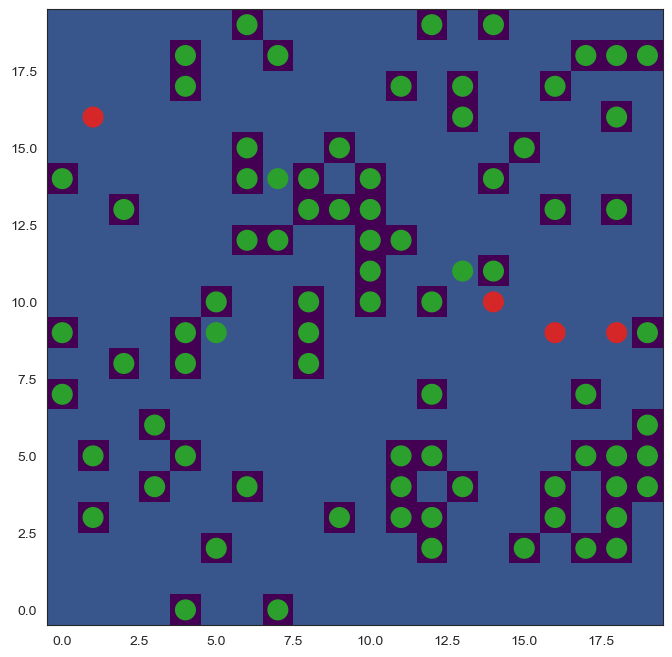

In [2]:
model = PredatorPreyModel()
visualize_model(model)
model.step()
visualize_model(model)
plt.show()

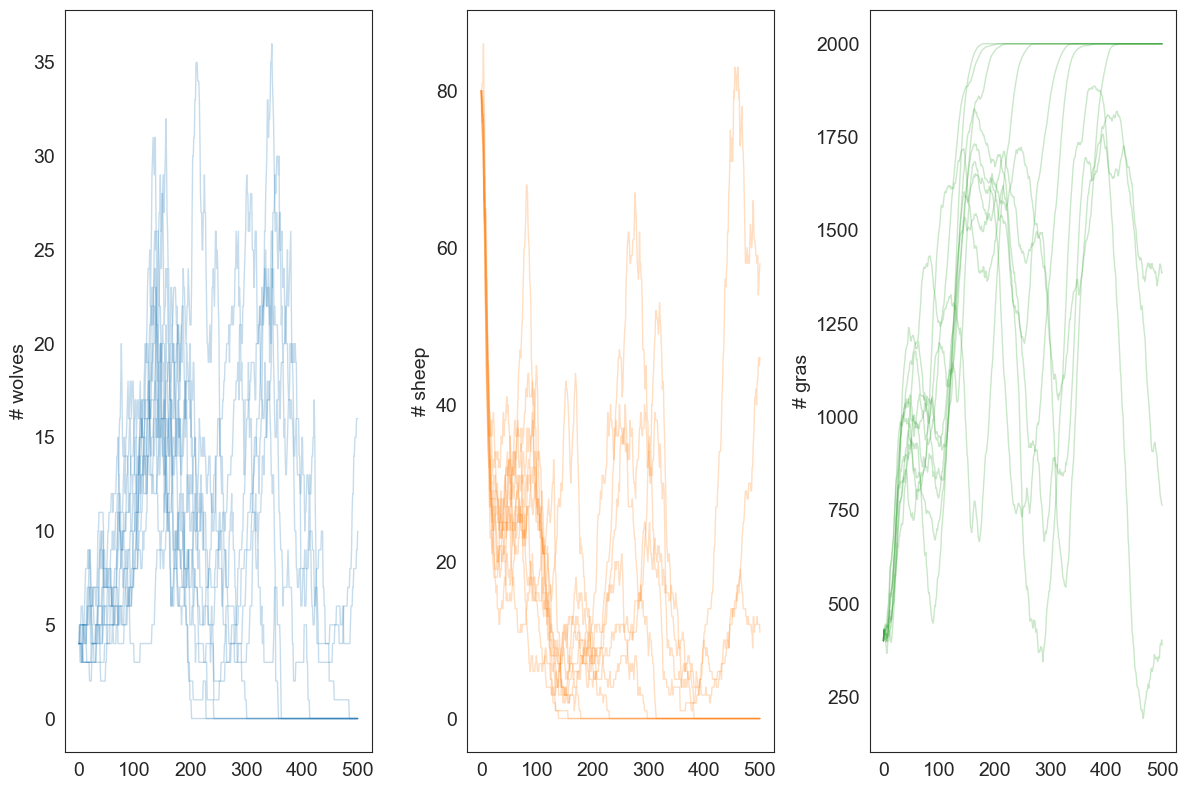

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
ax1.set_ylabel('# wolves')
ax2.set_ylabel('# sheep')
ax3.set_ylabel('# gras')    

for i in range(10):

    model = PredatorPreyModel(seed=i)
    for _ in range(500):
        model.step()
    data = model.datacollector.get_model_vars_dataframe()
    ax1.plot(data.wolves, color=sns.color_palette()[0], lw=1, alpha=0.25)
    ax2.plot(data.sheep, color=sns.color_palette()[1], lw=1, alpha=0.25)
    ax3.plot(data.grass, color=sns.color_palette()[2], lw=1, alpha=0.25)

change_fontsize(fig, 14)
plt.tight_layout()
plt.show()





# experiments

change regrowth probability and ask to explain behavior in terms of delays....

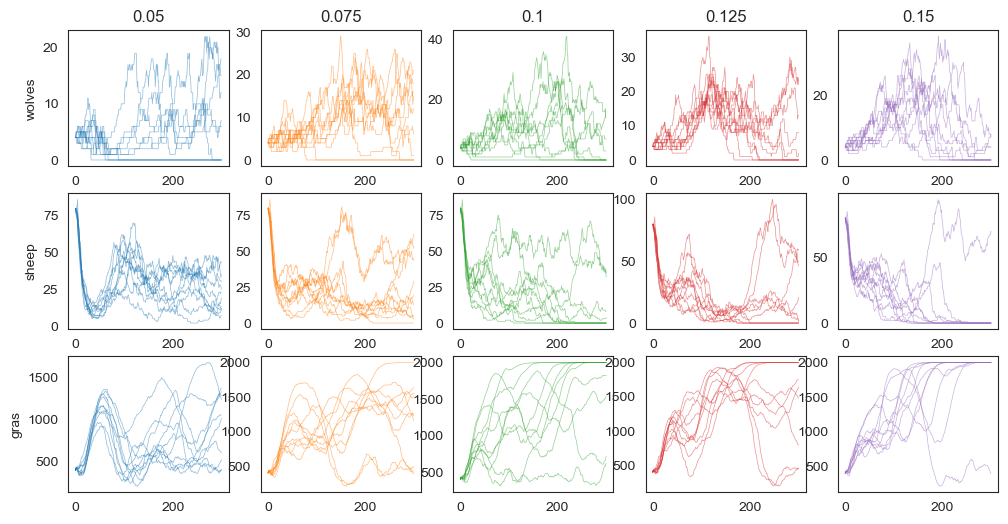

In [4]:
from collections import defaultdict


fig, axes = plt.subplots(nrows=3, ncols=5,
                        figsize=(12,6))
axes1, axes2, axes3 = axes

results = defaultdict(list)
for i, p in enumerate([0.05, 0.075, 0.1, 0.125, 0.15]):
    color = sns.color_palette()[i]
    
    ax1 = axes1[i]
    ax2 = axes2[i]
    ax3 = axes3[i]

    if i==0:
        ax1.set_ylabel("wolves")
        ax2.set_ylabel("sheep")
        ax3.set_ylabel("gras")

    ax1.set_title(f"{p}")
        
    for s in range(10):
        model = PredatorPreyModel(regrowth_p=p, seed=s)
        for _ in range(300):
            model.step()
        data = model.datacollector.get_model_vars_dataframe()
        ax1.plot(data.wolves, color=color, lw=0.5, alpha=0.5)
        ax2.plot(data.sheep, color=color, lw=0.5, alpha=0.5) 
        ax3.plot(data.grass, color=color, lw=0.5, alpha=0.5) 


plt.show()

